In [1]:
from notebook_functions import Process
from notebook_functions import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier


%load_ext autoreload
%autoreload 2

train_import = pd.read_csv('../data/census_income_learn.csv', header=None)
test_import = pd.read_csv('../data/census_income_test.csv')
train = Process(train_import, is_training=True)
train.fit()
test = Process(test_import, is_training=False)
test.fit()


/Users/alexbrostoff/us-census/nbs/notebook_functions.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(axis=0, thresh=18, inplace=True)


# Modeling: Choosing a model

* want the model to perform well, but also be interpretable so that we can understand the features, their importance, how they interact, and how they help determine annual income - don't want to use an unexplainable model like a neural network - want to keep it simple
* Because we have a lot of categorical data - we want to use a tree method.
* Question now is bagging vs boosting - general rule
  * Shallow trees that have high bias low variance - underfitting, use boosting 
  * Deep trees with high variance and low bias - use bagging
* Bagging technique seems to be more fitting with our data, but will try both
  * didn't get great results with random forest, as the precision for the minority class (now balanced) was quite low
  * Trying cat boost - fitting for our data because it works especially well for categorical features - gradient boosting (boosting technique)
  
  
  <div class="alert alert-warning"><b>IMPORTANT:</b> We want to be explainable</div>



In [76]:
features = ['age', 'education', 'marital_stat', 'sex',
        'tax_filer_stat', 
       'num_persons_worked_for_employer',  'citizenship',
       'own_business_or_self_employed',
       'weeks_worked_in_year',  'race', 'hispanic_origin','immigrant_score']

X_train = pd.get_dummies(pd.concat([train.data[features], test.data[features]])).iloc[:train.data.shape[0]].drop(['sex_Male'], axis=1)
X_test = pd.get_dummies(pd.concat([train.data[features], test.data[features]])).iloc[train.data.shape[0]:].drop(['sex_Male'], axis=1)
y_train = train.data['income']
y_test = test.data['income']
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [77]:
clf = RandomForestClassifier(max_depth=20, random_state=0, min_samples_split=2, criterion='entropy')
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_valid)

plt.rcParams.update({'figure.figsize': (5.0, 5)})
print(classification_report(y_valid, y_pred_rf))
plot_confusion_matrix(clf, X_valid, y_valid)


## Statistics

In [78]:
FP = confusion_matrix(y_valid, y_pred_rf)[0][1]
TP = confusion_matrix(y_valid, y_pred_rf)[1][1]
FN = confusion_matrix(y_valid, y_pred_rf)[1][0]
TN = confusion_matrix(y_valid, y_pred_rf)[1][1]

In [79]:
# False Positive Rate: When it predicts over 50k, how often is it actually under 50k? When does it falsely assign the positive class?
FPR = FP/(FP+FN) 
print(f"Our model's False Positive Rate is {FPR}, meaning that the model is very good at predicting over 50k when it is actually over 50k")

# False Negative Rate: of all the ones that are actually over 50k, how many were predicted under 50k? Again, when does it falsely assign the positive class
FNR = FN/(FN+TP)
print(f"Our model's False Negative Rate is {FNR}, meaning that the model doesn't predict under 50k when it's actually over 50k very often")

# True Positive Rate/Recall: How many over 50k's were caught by the model, and how many 'slipped through'?
TPR = TP/(FN+TP)
# Cons: Doesn't take False Positive into account 
print(f"Our model's True Positive Rate is {TPR}, meaning that most over 50k's are caught")


# True Negative Rate: When it predicts under 50k, how often is it under over 50k? - how many negatives were falsely assigned positives 
TNR = TN/(TN+FP)
print(f"Our model's True Negative Rate is {TPR}, meaning that around 35% of our negatives are falsely assigned positives")

# Precision: Of all the ones predicted over 50k, how many are actually over 50k 
Precision = TP/(TP+FP) 
# Cons: Doesn't take false negative into account 
print(f"Our model's Precision is {Precision}, meaning that only about 35% of the predicted positives are actually positive ")


# Our problem: Our False Positives are very high, meaning that the model predicts a lot of people to have over 50k when in reality they do not. 

Our model's False Positive Rate is 0.901111474338019, meaning that the model is very good at predicting over 50k when it is actually over 50k
Our model's False Negative Rate is 0.18953634085213034, meaning that the model doesn't predict under 50k when it's actually over 50k very often
Our model's True Positive Rate is 0.8104636591478697, meaning that most over 50k's are caught
Our model's True Negative Rate is 0.8104636591478697, meaning that around 35% of our negatives are falsely assigned positives
Our model's Precision is 0.31938271604938273, meaning that only about 35% of the predicted positives are actually positive 


* Want to decrease our false positives


## Tuning My Model

### Cross Validation

In [80]:
### Cross Validation
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)

[0.76360768 0.75834867 0.76597423 0.77070734 0.77064703]


scores - not much of a difference

In [83]:
print(classification_report(y_valid, y_pred_rf))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     20694
           1       0.32      0.81      0.46      3192

    accuracy                           0.74     23886
   macro avg       0.64      0.77      0.65     23886
weighted avg       0.88      0.74      0.78     23886



In [84]:
# How could we improve false positives?
# In the future, could try some anomoly detection, since the positive class is over 5% of the data, 
# we can use isolation forest (if it was very small we would want to use outlier detection) - but I am unsure if there are any features that could really
# make this that effective

test.data.income.value_counts()
test.data.groupby('income').count()['index'].apply(lambda x: f"{round(x/test.data.shape[0]*100, 2)}%")
# Since the positive class is over 5% of the data, we can use isolation forest (if it was very small we would want to use outlier detection)

income
0    86.64%
1    13.36%
Name: index, dtype: object

# Tuning Model

<div class="alert alert-warning"><b>Note:</b> Normally, I would want to run a grid search to find the best parameters. Because this is very computationally expensive, it takes a while to run locally. For the sake of time I will not run it for this project, but normally it's a good idea for finding the best parameters for your model. </div>


In [87]:
n_estimators = [500, 800, 1500, 2500, 5000]
max_features = ['audio', 'sqrt', 'log2']
max_depth = [10,20,30,40,50]
min_samples_split = [2,5,10,15,20]
min_samples_leaf = [1,2,5,10,15]

grid_param = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

In [86]:
# from sklearn.model_selection import RandomizedSearchCV
# rfc = RandomForestClassifier()
# rfr_random = RandomizedSearchCV(estimator=rfc,
#                                param_distributions = grid_param,
#                                n_iter = 500,
#                                cv = 5,
#                                verbose = 2, n_jobs=-1)

# rfc_random.fit(X_train, y_train)
# print(rfr_random.best_params)

# Testing Data

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     10195
           1       0.32      0.81      0.46      1571

    accuracy                           0.74     11766
   macro avg       0.64      0.77      0.64     11766
weighted avg       0.88      0.74      0.78     11766



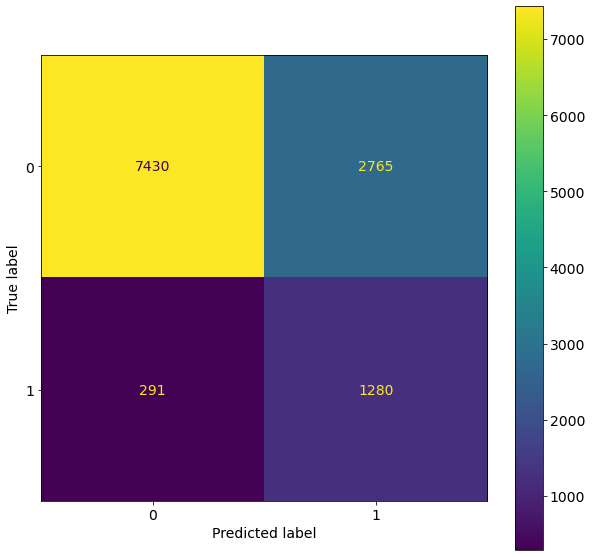

In [92]:
plt.rcParams.update({'figure.figsize': (10, 10)})
plt.rcParams.update({'font.size': 14})

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(clf, X_test, y_test)


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.49')

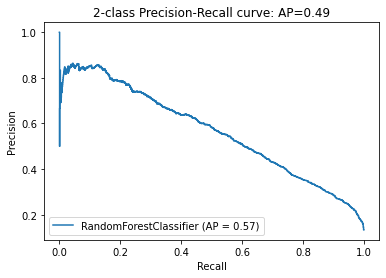

In [263]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

## Plotting Feature Importance

* Show Feature importance - and the correlations between these important features and our label
* Show tree based model - just showing a shallow tree for vizualization purposes
* You can thus see the most importance features to income through the graph, and can see that feature's correlation to our label to understand how that feature impacts income.

Text(0.5, 0, 'Random Forest Feature Importance')

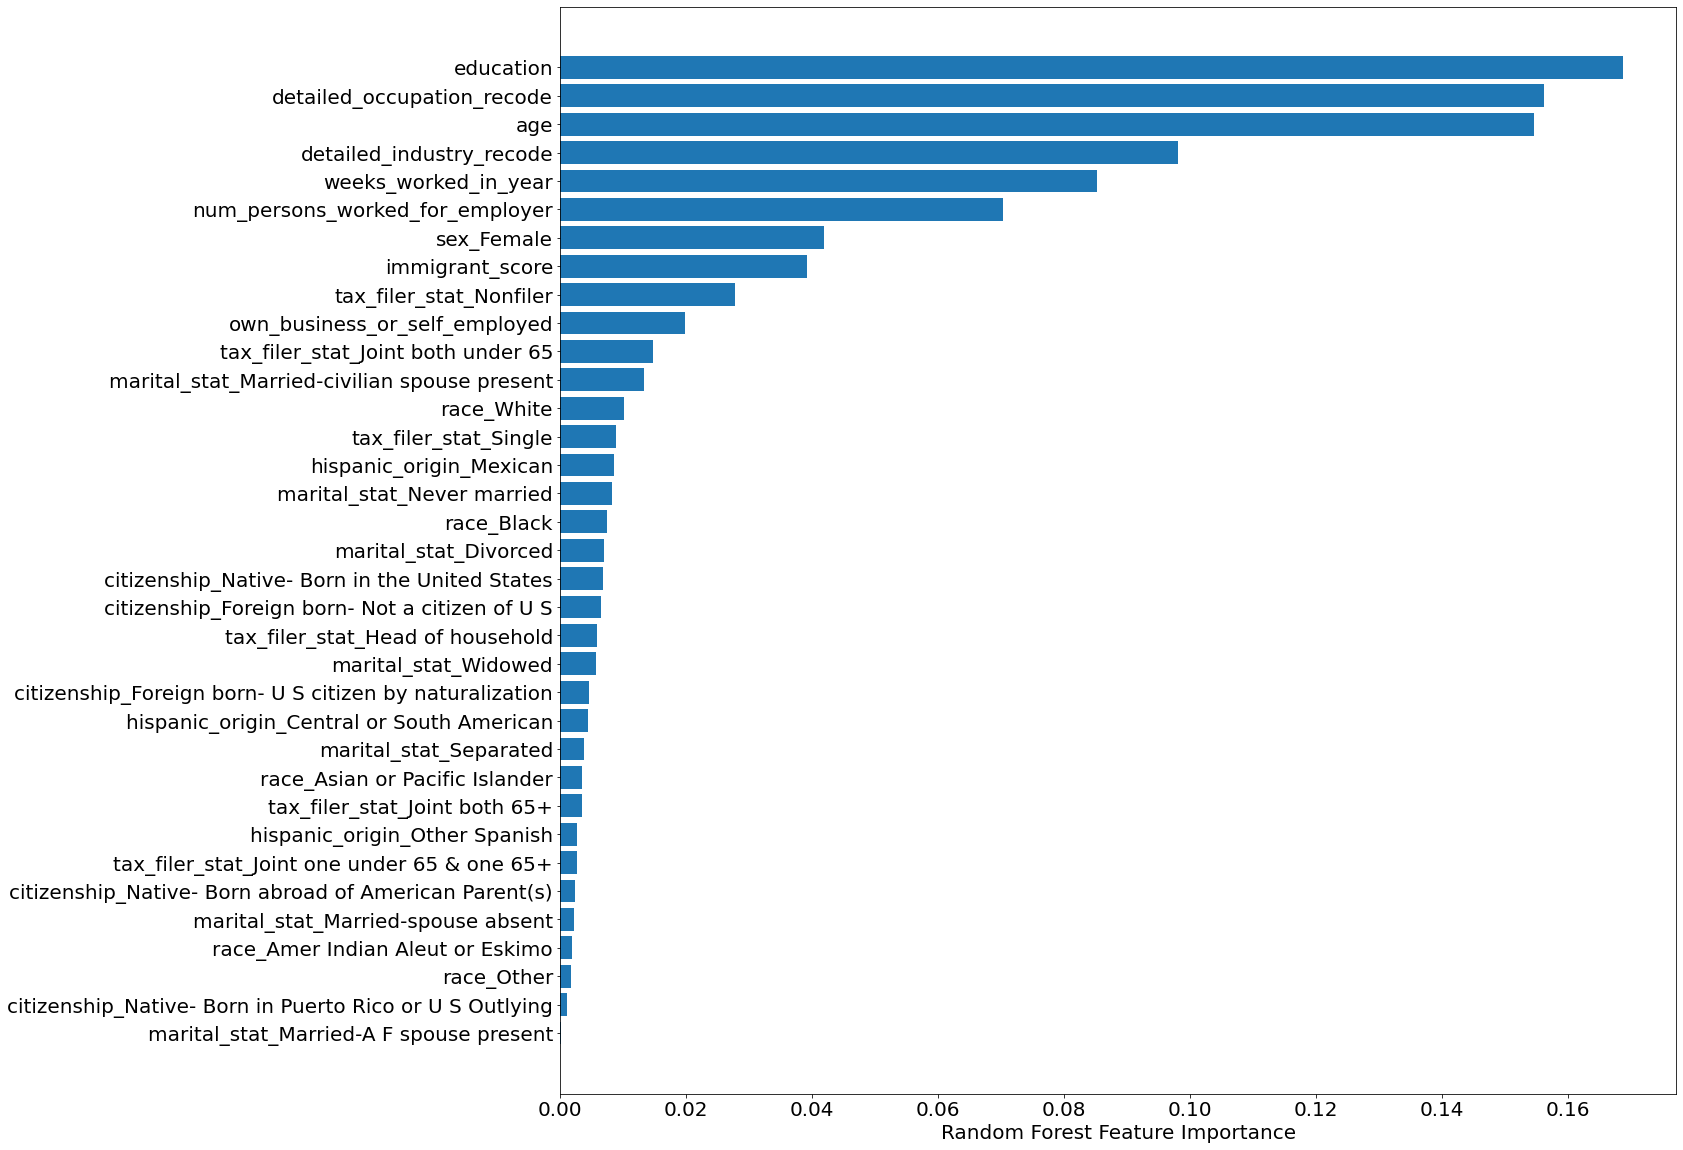

In [12]:
plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 20})
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")


In [18]:
data = X_train.copy()
data['income']=y_train
data.corr()['sex_Female']
data.corr().loc[['age', 'education', 'sex_Female', 'immigrant_score', 'num_persons_worked_for_employer', 'weeks_worked_in_year', 'race_White', 'hispanic_origin_Mexican']][['income']]

,income
age,-0.010086
education,0.476787
sex_Female,-0.285885
immigrant_score,0.075955
num_persons_worked_for_employer,0.280699
weeks_worked_in_year,0.366602
race_White,0.111633
hispanic_origin_Mexican,-0.117922


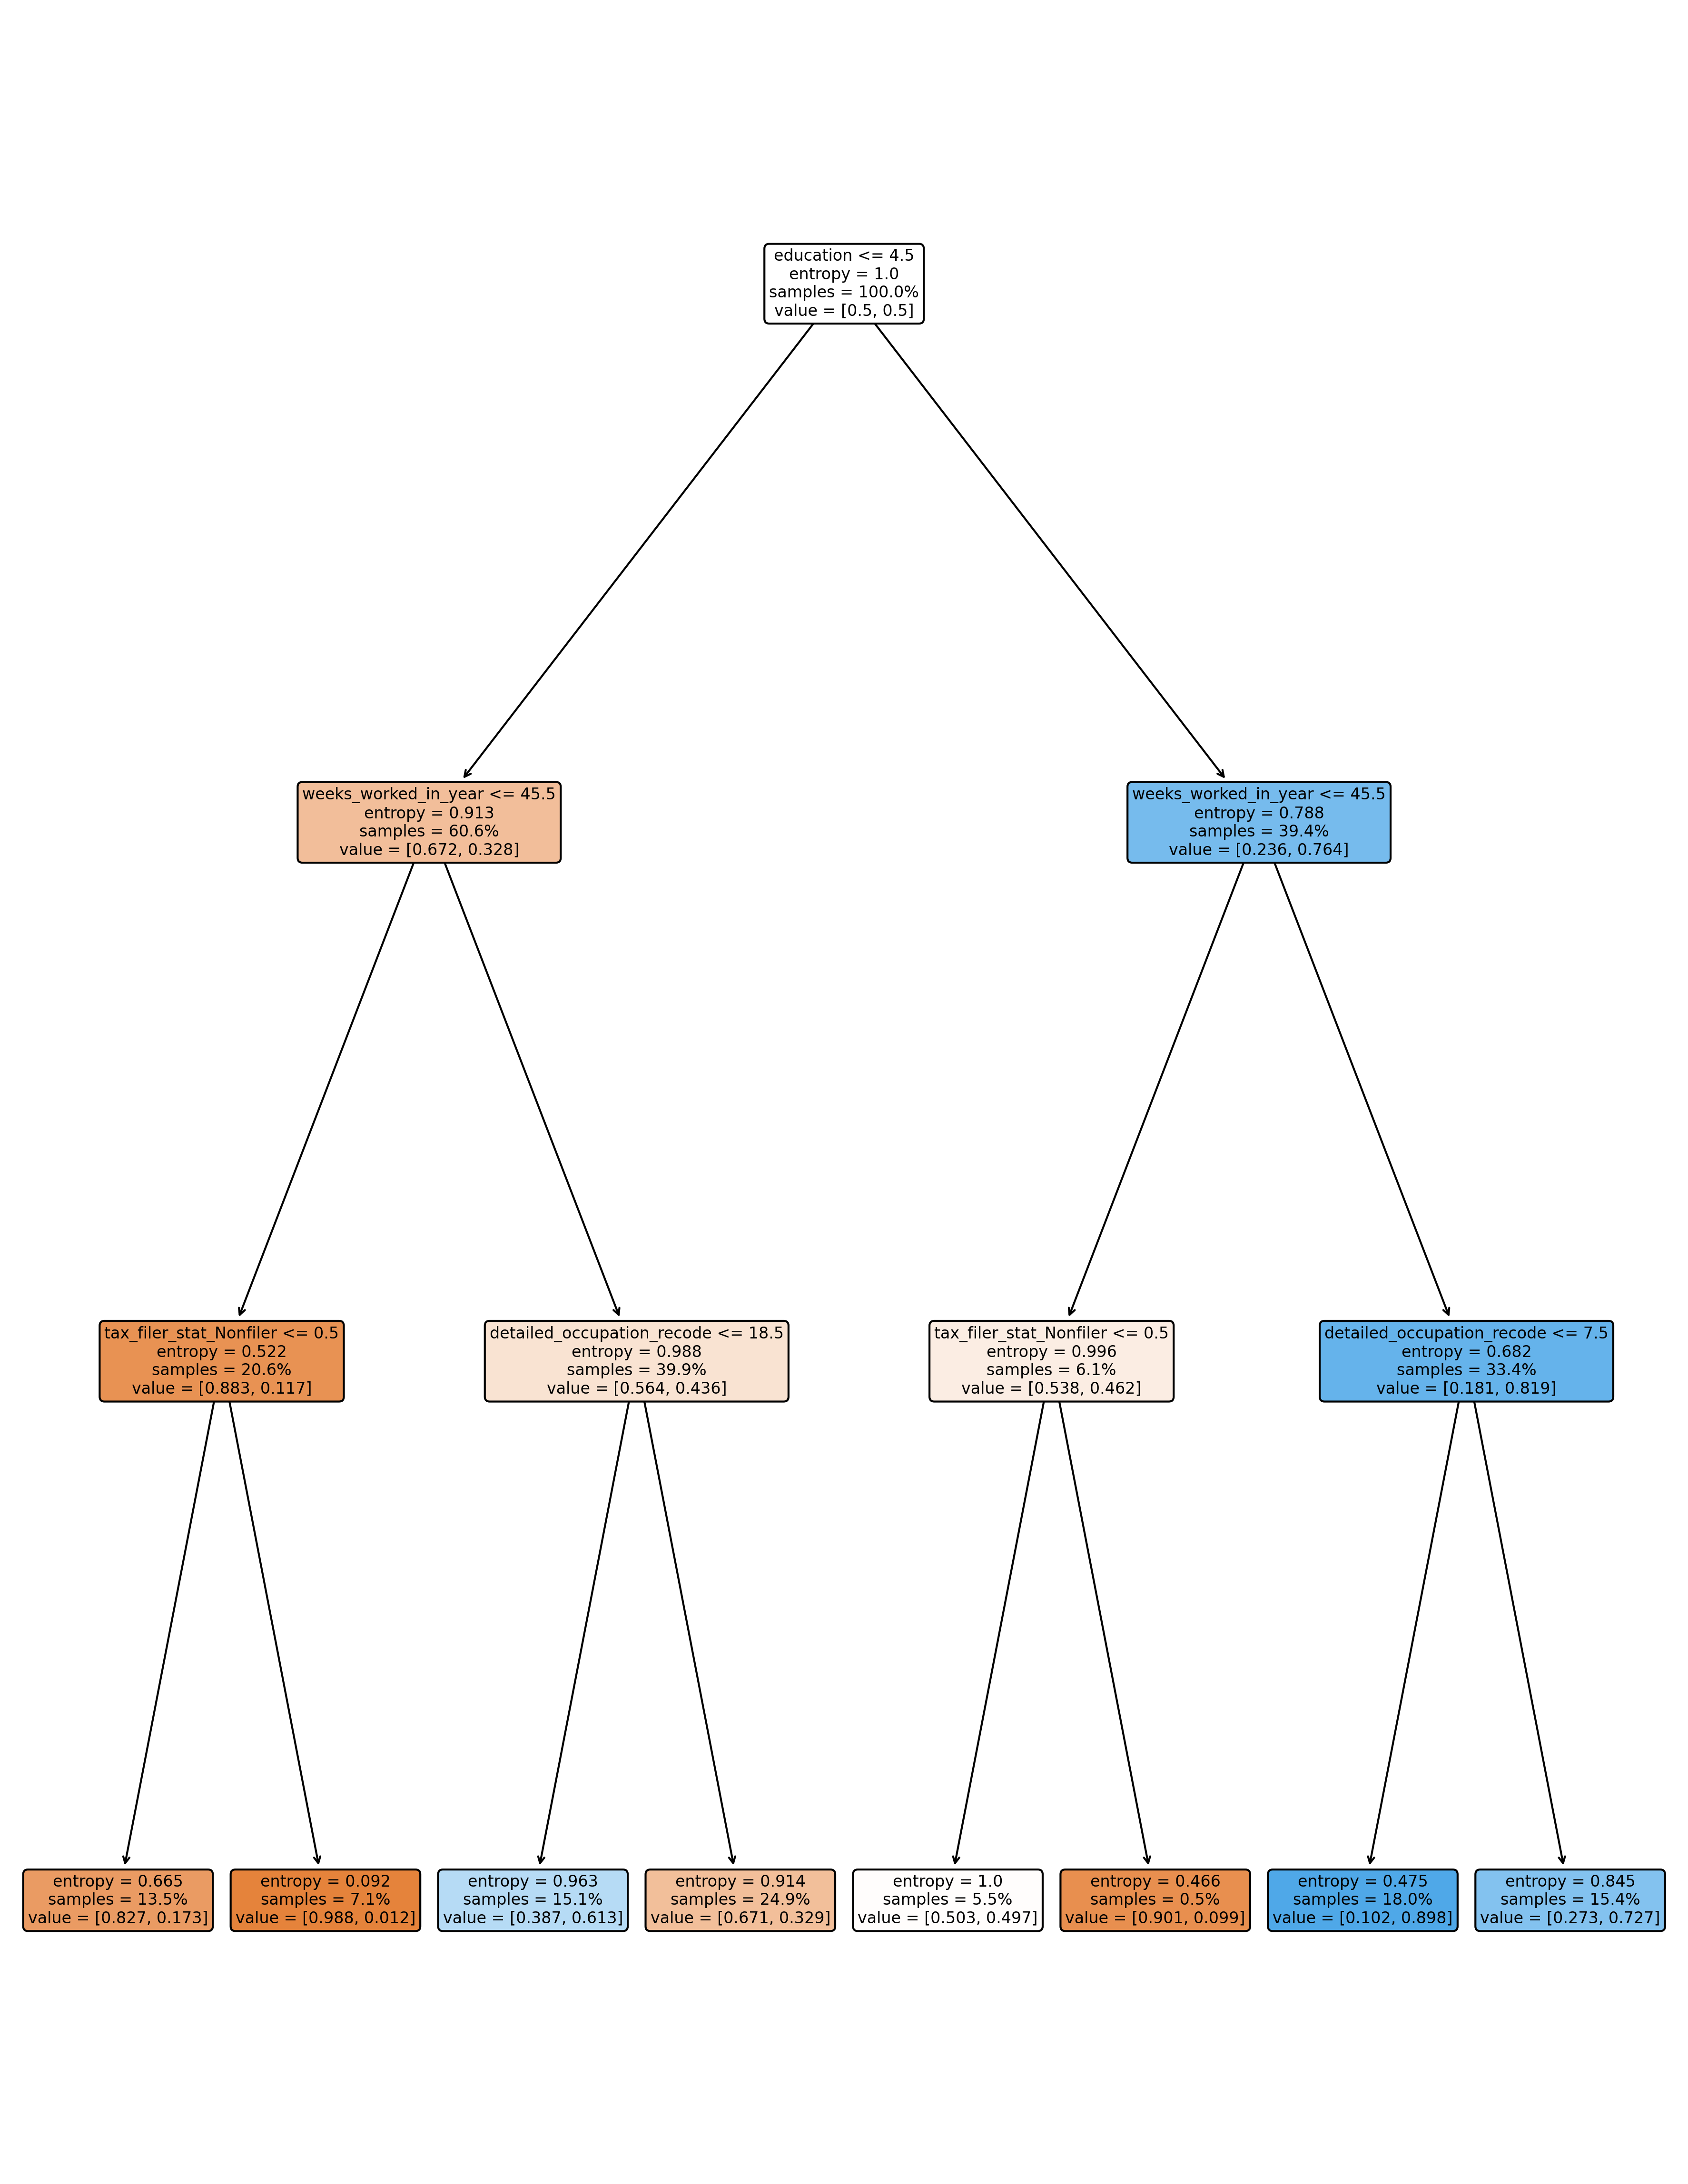

In [75]:
clf_vizualization = DecisionTreeClassifier(max_depth=3, random_state=0, min_samples_split=2, criterion='entropy')
clf_vizualization.fit(X_train, y_train)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15,20), dpi=300)

tree.plot_tree(clf_vizualization,
               feature_names = X_train.columns, 
               filled = True,
                   rounded=True,
                   fontsize=8,
                proportion=True);
fig.savefig('tree.png')
